<a href="https://colab.research.google.com/github/Faisal-NSU/MachineLearning/blob/main/Pytorch_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Backpropagation


In [ ]:
import torch

x = torch.tensor(1.0)
y = torch.tensor(2.0)

# This is the parameter we want to optimize -> requires_grad=True
w = torch.tensor(1.0, requires_grad=True)

# forward pass to compute loss
y_predicted = w * x
loss = (y_predicted - y)**2
print(loss)

# backward pass to compute gradient dLoss/dw
loss.backward()
print(w.grad)

# update weights, this operation should not be part of the computational graph
with torch.no_grad():
    w -= 0.01 * w.grad
# don't forget to zero the gradients
w.grad.zero_()

# next forward and backward pass...

tensor(1., grad_fn=<PowBackward0>)
tensor(-2.)


tensor(0.)

Custom Linear Model with Pytorch Loss and Optimizer

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
# 0) Prepare data
bc = datasets.load_breast_cancer()
X, y = bc.data, bc.target

n_samples, n_features = X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# scale
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)


In [ ]:
y_train.shape

torch.Size([455, 1])

In [ ]:
# 1) Model
# Linear model f = wx + b , sigmoid at the end
class Model(nn.Module):
    def __init__(self, n_input_features):
        super(Model, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)

    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

model = Model(n_features)

In [ ]:
print(model)

Model(
  (linear): Linear(in_features=30, out_features=1, bias=True)
)


In [ ]:
# 2) Loss and optimizer
num_epochs = 100
learning_rate = 0.01
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
# 3) Training loop
for epoch in range(num_epochs):
    # Forward pass and loss
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    # Backward pass and update
    loss.backward()
    optimizer.step()

    # zero grad before new step
    optimizer.zero_grad()

    if (epoch+1) % 10 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

with torch.no_grad():
    y_predicted = model(X_test)
    y_predicted_cls = y_predicted.round()
    acc = y_predicted_cls.eq(y_test).sum() / float(y_test.shape[0])
    print(f'accuracy: {acc.item():.4f}')

epoch: 10, loss = 0.7219
epoch: 20, loss = 0.5659
epoch: 30, loss = 0.4735
epoch: 40, loss = 0.4132
epoch: 50, loss = 0.3706
epoch: 60, loss = 0.3387
epoch: 70, loss = 0.3139
epoch: 80, loss = 0.2938
epoch: 90, loss = 0.2771
epoch: 100, loss = 0.2630
accuracy: 0.9123


Pytorch Softmax and Cross-entropy

In [ ]:
import numpy as np
#
#        -> 2.0              -> 0.65  
# Linear -> 1.0  -> Softmax  -> 0.25   -> CrossEntropy(y, y_hat)
#        -> 0.1              -> 0.1                   
#
#     scores(logits)      probabilities
#                           sum = 1.0
#

# Softmax applies the exponential function to each element, and normalizes
# by dividing by the sum of all these exponentials
# -> squashes the output to be between 0 and 1 = probability
# sum of all probabilities is 1

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

x = np.array([2.0, 1.0, 0.1])
outputs = softmax(x)
print('softmax numpy:', outputs)

x = torch.tensor([2.0, 1.0, 0.1])
outputs = torch.softmax(x, dim=0) # along values along first axis
print('softmax torch:', outputs)

softmax numpy: [0.65900114 0.24243297 0.09856589]
softmax torch: tensor([0.6590, 0.2424, 0.0986])


In [ ]:
# Cross entropy
# Cross-entropy loss, or log loss, measures the performance of a classification model 
# whose output is a probability value between 0 and 1. 
# -> loss increases as the predicted probability diverges from the actual label

# CrossEntropyLoss in PyTorch (applies Softmax)
# nn.LogSoftmax + nn.NLLLoss
# NLLLoss = negative log likelihood loss
loss = nn.CrossEntropyLoss()
# loss(input, target)

# target is of size nSamples = 1
# each element has class label: 0, 1, or 2
# Y (=target) contains class labels, not one-hot
Y = torch.tensor([0])

In [ ]:
# input is of size nSamples x nClasses = 1 x 3
# y_pred (=input) must be raw, unnormalizes scores (logits) for each class, not softmax
Y_pred_good = torch.tensor([[2.0, 1.0, 0.1]])
Y_pred_bad = torch.tensor([[0.5, 2.0, 0.3]])
l1 = loss(Y_pred_good, Y)
l2 = loss(Y_pred_bad, Y)

print(f'PyTorch Loss1: {l1.item():.4f}')
print(f'PyTorch Loss2: {l2.item():.4f}')

# get predictions
_, predictions1 = torch.max(Y_pred_good, 1)
_, predictions2 = torch.max(Y_pred_bad, 1)
print(f'Actual class: {Y.item()}, Y_pred1: {predictions1.item()}, Y_pred2: {predictions2.item()}')

PyTorch Loss1: 0.4170
PyTorch Loss2: 1.8406
Actual class: 0, Y_pred1: 0, Y_pred2: 1


In [ ]:
# allows batch loss for multiple samples

# let batch size: 3 and no. of classes is also 3
# each element has class label: 0, 1, or 2
Y = torch.tensor([2, 0, 1])

# input is of size Batch x nClasses = 3 x 3
# Y_pred are logits (not softmax)
Y_pred_good = torch.tensor(
    [[0.1, 0.2, 3.9], # predict class 2
    [1.2, 0.1, 0.3], # predict class 0
    [0.3, 2.2, 0.2]]) # predict class 1

Y_pred_bad = torch.tensor(
    [[0.9, 0.2, 0.1],
    [0.1, 0.3, 1.5],
    [1.2, 0.2, 0.5]])

l1 = loss(Y_pred_good, Y)
l2 = loss(Y_pred_bad, Y)
print(f'Batch Loss1:  {l1.item():.4f}')
print(f'Batch Loss2: {l2.item():.4f}')

# get predictions
_, predictions1 = torch.max(Y_pred_good, 1)
_, predictions2 = torch.max(Y_pred_bad, 1)
print(f'Actual class: {Y}, Y_pred1: {predictions1}, Y_pred2: {predictions2}')

TypeError: ignored

In [ ]:
# Binary classification
class NeuralNet1(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet1, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, 1)  
    
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        # sigmoid at the end
        y_pred = torch.sigmoid(out)
        return y_pred

model = NeuralNet1(input_size=28*28, hidden_size=5)
criterion = nn.BCELoss()

# Multiclass problem
class NeuralNet2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet2, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        # no softmax at the end
        return out

model = NeuralNet2(input_size=28*28, hidden_size=5, num_classes=3)
criterion = nn.CrossEntropyLoss()  # (applies Softmax)

Activation Funtions

In [ ]:
# output = w*x + b
# output = activation_function(output)
import torch
import torch.nn as nn
import torch.nn.functional as F

x = torch.tensor([-1.0, 1.0, 2.0, 3.0])

# sofmax
output = torch.softmax(x, dim=0)
print(output)
sm = nn.Softmax(dim=0)
output = sm(x)
print(output)

# sigmoid 
output = torch.sigmoid(x)
print(output)
s = nn.Sigmoid()
output = s(x)
print(output)

#tanh
output = torch.tanh(x)
print(output)
t = nn.Tanh()
output = t(x)
print(output)

# relu
output = torch.relu(x)
print(output)
relu = nn.ReLU()
output = relu(x)
print(output)

# leaky relu
output = F.leaky_relu(x)
print(output)
lrelu = nn.LeakyReLU()
output = lrelu(x)
print(output)

tensor([0.0120, 0.0889, 0.2418, 0.6572])
tensor([0.0120, 0.0889, 0.2418, 0.6572])
tensor([0.2689, 0.7311, 0.8808, 0.9526])
tensor([0.2689, 0.7311, 0.8808, 0.9526])
tensor([-0.7616,  0.7616,  0.9640,  0.9951])
tensor([-0.7616,  0.7616,  0.9640,  0.9951])
tensor([0., 1., 2., 3.])
tensor([0., 1., 2., 3.])
tensor([-0.0100,  1.0000,  2.0000,  3.0000])
tensor([-0.0100,  1.0000,  2.0000,  3.0000])


In [ ]:
#nn.ReLU() creates an nn.Module which you can add e.g. to an nn.Sequential model.
#torch.relu on the other side is just the functional API call to the relu function,
#so that you can add it e.g. in your forward method yourself.

# option 1 (create nn modules)
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.sigmoid(out)
        return out

# option 2 (use activation functions directly in forward pass)
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out = torch.relu(self.linear1(x))
        out = torch.sigmoid(self.linear2(out))
        return out

Plotting the Activation Functions

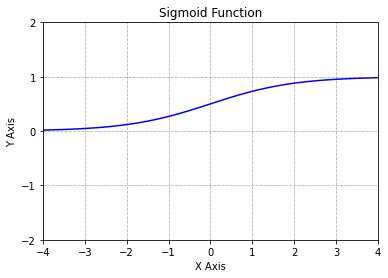

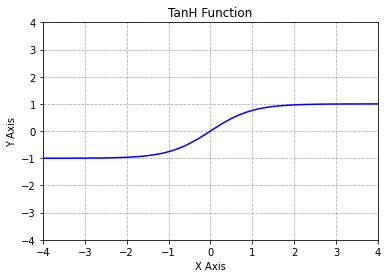

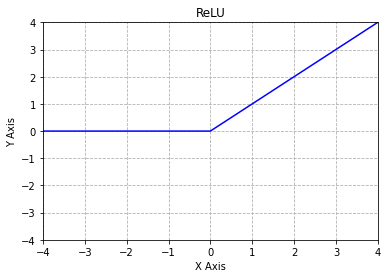

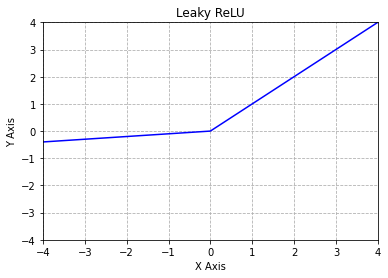

done


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
##### Sigmoid
sigmoid = lambda x: 1 / (1 + np.exp(-x))

x=np.linspace(-10,10,10)

y=np.linspace(-10,10,100)

fig = plt.figure()
plt.plot(y,sigmoid(y),'b', label='linspace(-10,10,100)')

plt.grid(linestyle='--')

plt.xlabel('X Axis')

plt.ylabel('Y Axis')

plt.title('Sigmoid Function')

plt.xticks([-4, -3, -2, -1, 0, 1, 2, 3, 4])
plt.yticks([-2, -1, 0, 1, 2])

plt.ylim(-2, 2)
plt.xlim(-4, 4)

plt.show()
#plt.savefig('sigmoid.png')

fig = plt.figure()

##### TanH
tanh = lambda x: 2*sigmoid(2*x)-1

x=np.linspace(-10,10,10)

y=np.linspace(-10,10,100)

plt.plot(y,tanh(y),'b', label='linspace(-10,10,100)')

plt.grid(linestyle='--')

plt.xlabel('X Axis')

plt.ylabel('Y Axis')

plt.title('TanH Function')

plt.xticks([-4, -3, -2, -1, 0, 1, 2, 3, 4])
plt.yticks([-4, -3, -2, -1, 0, 1, 2, 3, 4])

plt.ylim(-4, 4)
plt.xlim(-4, 4)

plt.show()
#plt.savefig('tanh.png')

fig = plt.figure()

##### ReLU
relu = lambda x: np.where(x>=0, x, 0)

x=np.linspace(-10,10,10)

y=np.linspace(-10,10,1000)

plt.plot(y,relu(y),'b', label='linspace(-10,10,100)')

plt.grid(linestyle='--')

plt.xlabel('X Axis')

plt.ylabel('Y Axis')

plt.title('ReLU')

plt.xticks([-4, -3, -2, -1, 0, 1, 2, 3, 4])
plt.yticks([-4, -3, -2, -1, 0, 1, 2, 3, 4])

plt.ylim(-4, 4)
plt.xlim(-4, 4)

plt.show()
#plt.savefig('relu.png')

fig = plt.figure()

##### Leaky ReLU
leakyrelu = lambda x: np.where(x>=0, x, 0.1*x)

x=np.linspace(-10,10,10)

y=np.linspace(-10,10,1000)

plt.plot(y,leakyrelu(y),'b', label='linspace(-10,10,100)')

plt.grid(linestyle='--')

plt.xlabel('X Axis')

plt.ylabel('Y Axis')

plt.title('Leaky ReLU')

plt.xticks([-4, -3, -2, -1, 0, 1, 2, 3, 4])
plt.yticks([-4, -3, -2, -1, 0, 1, 2, 3, 4])

plt.ylim(-4, 4)
plt.xlim(-4, 4)

plt.show()
#plt.savefig('lrelu.png')


print('done')

# **Feed Forward Neural Network**

In [ ]:
!nvidia-smi

Wed Dec  8 15:17:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    75W / 149W |    864MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



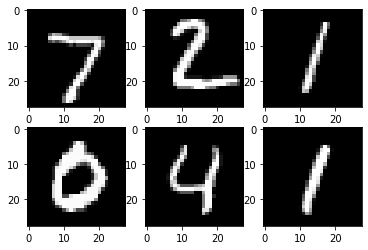

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = 784 # 28x28
hidden_size = 500 
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

examples = iter(test_loader)
example_data, example_targets = examples.next()

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

In [ ]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [ ]:
# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Epoch [1/2], Step [100/600], Loss: 0.2450
Epoch [1/2], Step [200/600], Loss: 0.1592
Epoch [1/2], Step [300/600], Loss: 0.1943
Epoch [1/2], Step [400/600], Loss: 0.1936
Epoch [1/2], Step [500/600], Loss: 0.2437
Epoch [1/2], Step [600/600], Loss: 0.1391
Epoch [2/2], Step [100/600], Loss: 0.2242
Epoch [2/2], Step [200/600], Loss: 0.1441
Epoch [2/2], Step [300/600], Loss: 0.0757
Epoch [2/2], Step [400/600], Loss: 0.2200
Epoch [2/2], Step [500/600], Loss: 0.2500
Epoch [2/2], Step [600/600], Loss: 0.0827
Accuracy of the network on the 10000 test images: 96.73 %


# **CNN**

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


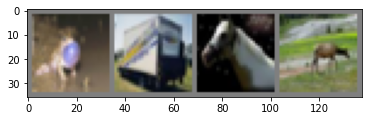

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 5
batch_size = 4
learning_rate = 0.001

# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)            # -> n, 400
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x


model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Epoch [1/5], Step [2000/12500], Loss: 2.3021
Epoch [1/5], Step [4000/12500], Loss: 2.2640
Epoch [1/5], Step [6000/12500], Loss: 2.2757
Epoch [1/5], Step [8000/12500], Loss: 2.2613
Epoch [1/5], Step [10000/12500], Loss: 2.0592
Epoch [1/5], Step [12000/12500], Loss: 2.3368
Epoch [2/5], Step [2000/12500], Loss: 1.9582
Epoch [2/5], Step [4000/12500], Loss: 1.5704
Epoch [2/5], Step [6000/12500], Loss: 1.9390
Epoch [2/5], Step [8000/12500], Loss: 2.0125
Epoch [2/5], Step [10000/12500], Loss: 1.8154
Epoch [2/5], Step [12000/12500], Loss: 1.7040
Epoch [3/5], Step [2000/12500], Loss: 1.8290
Epoch [3/5], Step [4000/12500], Loss: 2.1840
Epoch [3/5], Step [6000/12500], Loss: 1.0674
Epoch [3/5], Step [8000/12500], Loss: 0.8196
Epoch [3/5], Step [10000/12500], Loss: 1.4101
Epoch [3/5], Step [12000/12500], Loss: 1.5389
Epoch [4/5], Step [2000/12500], Loss: 1.9581
Epoch [4/5], Step [4000/12500], Loss: 1.0887
Epoch [4/5], Step [6000/12500], Loss: 1.2841
Epoch [4/5], Step [8000/12500], Loss: 2.2630
Epoc

# **Transfer Learning**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!7z x /content/drive/MyDrive/hymenoptera_data.zip -o'/content'


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 47286322 bytes (46 MiB)

Extracting archive: /content/drive/MyDrive/hymenoptera_data.zip
--
Path = /content/drive/MyDrive/hymenoptera_data.zip
Type = zip
Physical Size = 47286322

  0%    
Would you like to replace the existing file:
  Path:     /content/hymenoptera_data/train/ants/0013035.jpg
  Size:     46706 bytes (46 KiB)
  Modified: 2017-03-13 19:19:50
with the file from archive:
  Path:     hymenoptera_data/train/ants/0013035.jpg
  Size:     46706 bytes (46 KiB)
  Modified: 2017-03-13 19:19:50
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? s

  0% 3      Everything is Ok

Fo

In [ ]:
LOL = models.resnet18(pretrained=True)
print(LOL)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

['ants', 'bees']


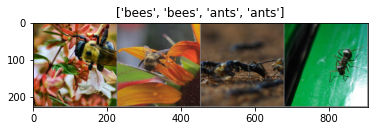

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 0/24
----------
train Loss: 0.6227 Acc: 0.6516
val Loss: 0.4651 Acc: 0.8366

Epoch 1/24
----------
train Loss: 0.5216 Acc: 0.7869
val Loss: 0.3592 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.4434 Acc: 0.8320
val Loss: 0.2866 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.4370 Acc: 0.8074
val Loss: 0.2603 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.3980 Acc: 0.8402
val Loss: 0.2401 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.3474 Acc: 0.8566
val Loss: 0.2138 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.3551 Acc: 0.8648
val Loss: 0.2092 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3359 Acc: 0.8689
val Loss: 0.2070 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3531 Acc: 0.8484
val Loss: 0.2097 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3448 Acc: 0.8811
val Loss: 0.2059 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3439 Acc: 0.8607
val Loss: 0.2086 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3361 Acc: 0.8770
val Loss: 0.1982 Acc: 0.9477

Ep

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)


def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(current_epochs, num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        
                        loss.backward()
                        optimizer.step()
                        optimizer.zero_grad()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)


#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)


# **Load & Save Models**

In [ ]:
import torch
import torch.nn as nn

''' 3 DIFFERENT METHODS TO REMEMBER:
 - torch.save(arg, PATH) # can be model, tensor, or dictionary
 - torch.load(PATH)
 - torch.load_state_dict(arg)
'''

''' 2 DIFFERENT WAYS OF SAVING
# 1) lazy way: save whole model
torch.save(model, PATH)

# model class must be defined somewhere
model = torch.load(PATH)
model.eval()

# 2) recommended way: save only the state_dict
torch.save(model.state_dict(), PATH)

# model must be created again with parameters
model = Model(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()
'''


class Model(nn.Module):
    def __init__(self, n_input_features):
        super(Model, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)

    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

model = Model(n_input_features=6)
# train your model...

####################save all ######################################
for param in model.parameters():
    print(param)

# save and load entire model

FILE = "model.pth"
torch.save(model, FILE)

loaded_model = torch.load(FILE)
loaded_model.eval()

for param in loaded_model.parameters():
    print(param)


############save only state dict #########################

# save only state dict
FILE = "model.pth"
torch.save(model.state_dict(), FILE)

print(model.state_dict())
loaded_model = Model(n_input_features=6)
loaded_model.load_state_dict(torch.load(FILE)) # it takes the loaded dictionary, not the path file itself
loaded_model.eval()

print(loaded_model.state_dict())


###########load checkpoint#####################
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

checkpoint = {
"epoch": 90,
"model_state": model.state_dict(),
"optim_state": optimizer.state_dict()
}
print(optimizer.state_dict())
FILE = "checkpoint.pth"
torch.save(checkpoint, FILE)

model = Model(n_input_features=6)
optimizer = optimizer = torch.optim.SGD(model.parameters(), lr=0)

checkpoint = torch.load(FILE)
model.load_state_dict(checkpoint['model_state'])
optimizer.load_state_dict(checkpoint['optim_state'])
epoch = checkpoint['epoch']

model.eval()
# - or -
# model.train()

print(optimizer.state_dict())

# Remember that you must call model.eval() to set dropout and batch normalization layers 
# to evaluation mode before running inference. Failing to do this will yield 
# inconsistent inference results. If you wish to resuming training, 
# call model.train() to ensure these layers are in training mode.

Parameter containing:
tensor([[ 0.2837, -0.1042,  0.0158, -0.1926,  0.2340, -0.1112]],
       requires_grad=True)
Parameter containing:
tensor([0.1494], requires_grad=True)
Parameter containing:
tensor([[ 0.2837, -0.1042,  0.0158, -0.1926,  0.2340, -0.1112]],
       requires_grad=True)
Parameter containing:
tensor([0.1494], requires_grad=True)
OrderedDict([('linear.weight', tensor([[ 0.2837, -0.1042,  0.0158, -0.1926,  0.2340, -0.1112]])), ('linear.bias', tensor([0.1494]))])
OrderedDict([('linear.weight', tensor([[ 0.2837, -0.1042,  0.0158, -0.1926,  0.2340, -0.1112]])), ('linear.bias', tensor([0.1494]))])
{'state': {}, 'param_groups': [{'lr': 0.01, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [0, 1]}]}
{'state': {}, 'param_groups': [{'lr': 0.01, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [0, 1]}]}


In [ ]:
""" SAVING ON GPU/CPU 

# 1) Save on GPU, Load on CPU
device = torch.device("cuda")
model.to(device)
torch.save(model.state_dict(), PATH)

device = torch.device('cpu')
model = Model(*args, **kwargs)
model.load_state_dict(torch.load(PATH, map_location=device))

# 2) Save on GPU, Load on GPU
device = torch.device("cuda")
model.to(device)
torch.save(model.state_dict(), PATH)

model = Model(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.to(device)

# Note: Be sure to use the .to(torch.device('cuda')) function 
# on all model inputs, too!

# 3) Save on CPU, Load on GPU
torch.save(model.state_dict(), PATH)

device = torch.device("cuda")
model = Model(*args, **kwargs)
model.load_state_dict(torch.load(PATH, map_location="cuda:0"))  # Choose whatever GPU device number you want
model.to(device)

# This loads the model to a given GPU device. 
# Next, be sure to call model.to(torch.device('cuda')) to convert the model’s parameter tensors to CUDA tensors
"""

' SAVING ON GPU/CPU \n\n# 1) Save on GPU, Load on CPU\ndevice = torch.device("cuda")\nmodel.to(device)\ntorch.save(model.state_dict(), PATH)\n\ndevice = torch.device(\'cpu\')\nmodel = Model(*args, **kwargs)\nmodel.load_state_dict(torch.load(PATH, map_location=device))\n\n# 2) Save on GPU, Load on GPU\ndevice = torch.device("cuda")\nmodel.to(device)\ntorch.save(model.state_dict(), PATH)\n\nmodel = Model(*args, **kwargs)\nmodel.load_state_dict(torch.load(PATH))\nmodel.to(device)\n\n# Note: Be sure to use the .to(torch.device(\'cuda\')) function \n# on all model inputs, too!\n\n# 3) Save on CPU, Load on GPU\ntorch.save(model.state_dict(), PATH)\n\ndevice = torch.device("cuda")\nmodel = Model(*args, **kwargs)\nmodel.load_state_dict(torch.load(PATH, map_location="cuda:0"))  # Choose whatever GPU device number you want\nmodel.to(device)\n\n# This loads the model to a given GPU device. \n# Next, be sure to call model.to(torch.device(\'cuda\')) to convert the model’s parameter tensors to CUDA 